In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Optional
import statsmodels.api as sm
from time import time

## Data Loading and Preparation

We first load price data OHLCV and clean it.

In [2]:
df = pd.read_pickle('../data/binance_1D_crypto_data.pkl')
df = df[df['open_time'].dt.date != df['open_time'].dt.date.max()]
df = df.drop_duplicates(keep='first')
df.head()

,open_time,open,high,low,close,volume,symbol
0,2024-06-17,0.09500000,0.29500000,0.09500000,0.21300000,1558854668.40000000,ZKUSDT
1,2024-06-18,0.21300000,0.23200000,0.18600000,0.22020000,1189119720.30000000,ZKUSDT
2,2024-06-19,0.22020000,0.24000000,0.21260000,0.22420000,727374424.10000000,ZKUSDT
3,2024-06-20,0.22420000,0.22420000,0.19100000,0.19830000,493478200.90000000,ZKUSDT
4,2024-06-21,0.19830000,0.20360000,0.17600000,0.18220000,382766488.90000000,ZKUSDT


High, Low, Close Prices are used to detect a breakout, volume is also used to confirm a trend. All assets/columns that have more than 10% null values are removed

In [3]:
def pivot_reindexed_data(df, value):
    new_df = df.pivot(values = value, columns = 'symbol', index = 'open_time')
    new_df = pd.DataFrame(new_df).astype(float)
    new_df = new_df.reindex(pd.date_range(new_df.index[0],new_df.index[-1],freq='1d'))
    return new_df

px_close = pivot_reindexed_data(df,'close').loc[:'2025-08']
# Omitting tickers with less than 90% of non null values.
px_close = px_close.loc[:,(px_close.notna().sum()/(px_close.shape[0]))>= 0.9]

px_high = pivot_reindexed_data(df,'high')[px_close.columns].loc[:'2025-08']
px_low = pivot_reindexed_data(df,'low')[px_close.columns].loc[:'2025-08']
vols = pivot_reindexed_data(df,'volume')[px_close.columns].loc[:'2025-08']

insample_start = pd.Timestamp("2021-06-01")
insample_end = pd.Timestamp("2023-12-31")

outsample_start = pd.Timestamp("2024-01-01")

px_close_train = px_close.loc[:insample_end]
px_high_train = px_high.loc[:insample_end]
px_low_train = px_low.loc[:insample_end]
vols_train = vols.loc[:insample_end]

In [4]:
px_close.tail()

symbol,1INCHUSDT,AAVEUSDT,ADAUSDT,ALGOUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,AXSUSDT,BCHUSDT,BNBUSDT,...,TRXUSDT,TUSDUSDT,TWTUSDT,UNIUSDT,USDCUSDT,VETUSDT,XLMUSDT,XRPUSDT,XTZUSDT,ZECUSDT
2025-08-27,0.2496,320.63,0.8509,0.2475,6.59,4.491,24.42,2.304,550.2,855.18,...,0.3451,0.9977,0.7581,9.854,0.9998,0.02487,0.3790,2.9688,0.7872,42.27
2025-08-28,0.2538,317.56,0.8576,0.2528,6.87,4.782,24.93,2.397,557.9,873.47,...,0.3451,0.9974,0.7541,10.018,0.9999,0.02561,0.3822,2.9665,0.7842,42.47
2025-08-29,0.2444,319.20,0.8266,0.2365,6.38,4.483,23.55,2.251,530.7,862.30,...,0.3385,0.9971,0.7352,9.633,0.9999,0.02425,0.3614,2.8195,0.7335,40.21
2025-08-30,0.2469,319.39,0.8224,0.2337,6.43,4.505,23.78,2.292,552.8,862.00,...,0.3390,0.9967,0.7383,9.726,0.9998,0.02471,0.3600,2.8181,0.7369,40.05
2025-08-31,0.2421,315.69,0.8113,0.2316,6.35,4.467,23.40,2.522,544.2,857.65,...,0.3410,0.9966,0.7368,9.619,0.9999,0.02414,0.3528,2.7757,0.7199,40.43


In [5]:
def drawdown(returns):
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative / rolling_max - 1)
    return drawdown

In [6]:
def duration(returns):
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative / rolling_max - 1)
    duration = (drawdown != 0).astype(int)
    if isinstance(returns, pd.DataFrame):
        ddd = pd.DataFrame(index = returns.index, columns = returns.columns)
        for col in returns.columns:
            ddd[col] = duration[col].groupby((duration[col] != duration[col].shift()).cumsum()).cumsum()
    else:
        ddd = duration.groupby((duration != duration.shift()).cumsum()).cumsum()
    return ddd

In [7]:
def calculate_metrics(returns, benchmark:Optional = False):
    """
    Compute total return, annualized return/vol, Sharpe, max drawdown, win rate.
    """
    
    cumulative = (1 + returns).cumprod()
    rolling_max = cumulative.cummax()
    drawdown = (cumulative / rolling_max - 1)
    duration = (drawdown != 0).astype(int)
    max_duration = duration.groupby((duration != duration.shift()).cumsum()).cumsum().max()

    cum_ret = cumulative.iloc[-1] - 1
    ann_vol = returns.std() * np.sqrt(365)
    ann_ret = returns.mean() * 365
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    max_dd = drawdown.min()

    # consider only non-zero returns as individual trades
    trade_rets = returns[returns != 0]
    win_rate   = (trade_rets > 0).sum() / len(trade_rets)
    
    
    metrics = pd.Series({
        "Cumulative Return": f"{(cum_ret * 100):.2f}%",
        "Annualized Return": f"{(ann_ret * 100):.2f}%",
        "Annualized Volatility": f"{(ann_vol * 100):.2f}%",
        "Sharpe Ratio": sharpe,
        "Max Drawdown": f"{(max_dd * 100):.2f}%",
        "Max Drawdown Duration": f"{(max_duration):.2f} days",
        "Win Rate": f"{(win_rate * 100):.2f}%"
    })
    
    if benchmark:
        bench_rets = px_close['BTCUSDT'].ffill().pct_change().loc[returns.index]
        X = sm.add_constant(bench_rets)
        y = returns
        model = sm.OLS(y, X).fit()
        alpha = model.params['const']
        beta  = model.params['BTCUSDT']
        active_rets = returns - beta * bench_rets
        IR = active_rets.mean() / active_rets.std() * np.sqrt(365)
    
        metrics["Info Ratio"] = IR
        
    else: metrics["Info Ratio"] = "N/A"

    return metrics

In [8]:
def backtest_with_costs(prices, port, tcost_bps = 20):
    ret = prices.ffill().pct_change()
    gross_ret = (port.shift() * ret).sum(axis=1)

    # Turnover
    turnover = (port.fillna(0) - port.shift().fillna(0)).abs().sum(axis=1)

    # Cost in return units
    cost = turnover * (tcost_bps * 1e-4)
    net_ret = gross_ret - cost

    return net_ret, gross_ret, turnover

In [9]:
def channel_bounds(high, low, le_lookback, se_lookback):
    """
    Highest high / lowest low over last 'lookback' bars, inclusive.
    """
    higher = high.rolling(le_lookback, min_periods=le_lookback).max()
    lower = low.rolling(se_lookback, min_periods=se_lookback).min()
    return higher, lower

In [10]:
def volume_filter_mask(volm, lookback, pctile):
    """
    True where today's volume > rolling quantile (time-series) over the last 'lookback' days.
    Uses yesterday's threshold to avoid lookahead.
    """
    q = volm.rolling(lookback, min_periods=lookback).quantile(pctile)
    return volm > q.shift(1)

In [11]:
def breakout_entries(high, low, close, le_lookback, se_lookback,
                     volm: Optional = None, vol_lb: Optional = None, vol_pct: Optional = None):
    """
    Long entry when close[t] > higher[t-1]
    Short entry when close[t] < lower[t-1]
    Optional: apply a volume filter.
    """
    higher_L, lower_S = channel_bounds(high, low, le_lookback, se_lookback)
    
    long_entry = close > higher_L.shift(1) 
    short_entry = close < lower_S.shift(1)

    if volm is not None and vol_lb and vol_pct is not None:
        vol_ok = volume_filter_mask(volm, lookback=vol_lb, pctile=vol_pct)
        long_entry  = long_entry & vol_ok
        short_entry = short_entry & vol_ok

    return long_entry.fillna(False), short_entry.fillna(False)

In [12]:
def exit_masks_channel_separate(high, low, close, exit_long_lookback, exit_short_lookback):
    """
    Long exit: close < lower(EL)[t-1]
    Short exit: close > upper(ES)[t-1]
    """
    higher_EL, lower_ES = channel_bounds(high, low, exit_short_lookback, exit_long_lookback)
    long_exit  = close < lower_ES.shift(1) 
    short_exit = close > higher_EL.shift(1) 
    
    return long_exit.fillna(False), short_exit.fillna(False)

In [13]:
def _age_matrix_from_positions(pos_df):
    """
    Compute per-asset holding age in bars for nonzero positions.
    Age resets to 1 on the bar a position is opened or flips side.
    """
    ages = []
    for c in pos_df.columns:
        x = pos_df[c].to_numpy()
        a = np.zeros_like(x, dtype=int)
        last = 0
        run = 0
        for i, v in enumerate(x):
            if v == 0:
                run = 0
            else:
                if v != last:
                    run = 1
                else:
                    run += 1
            a[i] = run
            last = v
        ages.append(pd.Series(a, index=pos_df.index, name=c))
    return pd.concat(ages, axis=1)

In [14]:
def build_positions(high, low, close, le_lookback, se_lookback, exit_params: Dict,
                        volm: Optional = None, vol_lb: Optional = None, vol_pct: Optional = None):
    """
    Builds positions using the channel and holding period exit logic.
    exit_params are:
      - 'M': int, max holding period (time-based exit)
      - 'exit_llb': int, long exit lookback
      - 'exit_slb': int, short exit lookback
    """
    nrows, ncols = close.shape
    pos = np.zeros((nrows, ncols), dtype=np.int8)

    # Entries
    long_entry, short_entry = breakout_entries(
        high, low, close, le_lookback, se_lookback,
        volm=volm, vol_lb=vol_lb, vol_pct=vol_pct)

    # Price-based exits (channel)
    el = int(exit_params.get("exit_llb", le_lookback))
    es = int(exit_params.get("exit_slb", se_lookback))
    long_exit_mask, short_exit_mask = exit_masks_channel_separate(high, low, close, el, es)

    # Event loop
    for t in range(1, nrows):
        pos[t] = pos[t-1]
        
        le = long_entry.iloc[t].to_numpy()
        se = short_entry.iloc[t].to_numpy()
        
        pos[t, le] = 1
        pos[t, se] = -1

        # Apply price-based exits (channel)
        long_exit_now  = long_exit_mask.iloc[t].to_numpy()
        short_exit_now = short_exit_mask.iloc[t].to_numpy()
        pos[t, (pos[t] > 0) & long_exit_now]  = 0
        pos[t, (pos[t] < 0) & short_exit_now] = 0

    pos_df = pd.DataFrame(pos, index=close.index, columns=close.columns)

    # Time-based exit
    M = int(exit_params.get("M", 0))
    if M > 0:
        age_df = _age_matrix_from_positions(pos_df)
        pos_df = pos_df.mask((age_df > M) & (pos_df != 0), 0)

    return pos_df

In [15]:
def combined_momentum_strat(high, low, close):
    #PORTFOLIO 1 - MA CROSSOVER
    short_window = 28
    long_window =  80

    prices = close
    ret = prices.ffill().pct_change()

    short_ma = ret.rolling(short_window, min_periods=short_window).mean()
    long_ma  = ret.rolling(long_window, min_periods=short_window).mean()

    signal = short_ma/long_ma - 1

    # normalizing the signal by rolling volatility
    signal = signal / ret.rolling(63, min_periods=30).std()
    signal = np.tanh(signal)

    gap = prices.rolling(short_window, min_periods=short_window).mean() \
            - prices.rolling(long_window, min_periods=short_window).mean()

    gap_max = gap.rolling(5, min_periods = 2).max()
    shrink_on_max = (1 - gap / gap_max).where(gap > 0)

    gap_min = gap.rolling(2, min_periods = 2).min()
    shrink_on_min = (gap_min / gap - 1).where(gap < 0)
    
    sigma = ret.rolling(15).std()
    signal[ shrink_on_max > (sigma*1)] = -1 * signal.abs()
    signal[ shrink_on_min > (sigma*2)] = 1 * signal.abs()
    
    signal = signal * np.sqrt(ret.rolling(180, min_periods = 30).std())
    port1 = signal.divide(signal.abs().sum(1),0)
    
    # PORTFOLIO 2 - CHANNEL BREAKOUT
    pos = build_positions(
    high, low, close,
    le_lookback=46, se_lookback=35, 
    exit_params={"M": 33, "exit_llb": 2, "exit_slb": 40},
    volm=vols, vol_lb=50, vol_pct=0.68 # <— trade only if volume > 70th pctile of last 50 bars
    )

    pos = pos * np.sqrt(ret.rolling(35, min_periods = 1).std())
    port2 = pos.divide(pos.abs().sum(1), 0)
       
    return port1, port2

In [16]:
def eqvol_weights(prices, port1, port2, window):
    ret = prices.ffill().pct_change()
    ret1 = (port1.shift()*ret).sum(1)
    ret2 = (port2.shift()*ret).sum(1)
    
    vol1_inv = (1 / ret1.rolling(window, min_periods = 20).std()).replace(np.inf, 0.0)
    vol2_inv = (1 / ret2.rolling(window, min_periods = 20).std()).replace(np.inf, 0.0)
    vol_df = pd.concat([vol1_inv, vol2_inv], axis=1)
    vol_df.columns = ["port1", "port2"]
    
    weight_sum = vol_df.sum(axis=1).replace(0, np.nan)
    port_w = vol_df.div(weight_sum, axis=0).fillna(0.0)

    assets = prices.columns
    portfolio = (
        port_w["port1"].values[:, None] * port1 +
        port_w["port2"].values[:, None] * port2
    )
    
    portfolio = pd.DataFrame(portfolio, index=prices.index, columns=assets)

    # Fully invested portfolio
    portfolio = portfolio.div(portfolio.abs().sum(axis=1), axis=0).fillna(0.0)

    return portfolio

## WALK FORWARD VALIDATION

In [17]:
# walk forward validation
splits = [
    ("2021-01", "2021-06", "2021-07", "2021-12"),
    ("2021-01", "2021-12", "2022-01", "2022-06"),
    ("2021-01", "2022-06", "2022-07", "2022-12"),
    ("2021-01", "2022-12", "2023-01", "2023-06"),
    ("2021-01", "2023-06", "2023-07", "2023-12"),
]

port1, port2 = combined_momentum_strat(px_high_train, px_low_train, px_close_train)

In [18]:
windows = [30, 60, 90, 120, 180, 365]
results = []
for split_id, (_, _, val_start, val_end) in enumerate(splits, 1):
    begin = time()
    for window in windows:
        port = eqvol_weights(px_close_train, port1, port2, window)
        net_ret, _, _ = backtest_with_costs(px_close_train[val_start:val_end], port[val_start:val_end])
        sharpe_val = calculate_metrics(net_ret, True)['Sharpe Ratio']
        results.append({
            "split": split_id,
            "window": window,
            "val_sharpe": sharpe_val
        })
    end = time()
    print(split_id," ",end-begin, " seconds")

cv_results = pd.DataFrame(results)

# Average validation performance
avg_scores = cv_results.groupby(["window"])["val_sharpe"].mean().reset_index()
best_params = avg_scores.loc[avg_scores["val_sharpe"].idxmax()]

print("\nAverage validation scores (top 5):")
print(avg_scores.sort_values("val_sharpe", ascending=False).head())

1   0.05963492393493652  seconds
2   0.05637311935424805  seconds
3   0.05394792556762695  seconds
4   0.055544137954711914  seconds
5   0.05451011657714844  seconds

Average validation scores (top 5):
   window  val_sharpe
1      60    1.434865
5     365    1.431415
2      90    1.429017
3     120    1.414250
4     180    1.363418


In [19]:
cv_results.groupby('window')['val_sharpe'].apply(lambda x : (x < 0).sum())

window
30     1
60     1
90     1
120    1
180    1
365    1
Name: val_sharpe, dtype: int64

**Observe:** Every rolling window has one validation window with a negative sharpe

In [20]:
print("Parameters with non negative scores across all validation sets: ")
a_filter =(cv_results.groupby(["window"])["val_sharpe"].min() > -0.3).reset_index()
print(avg_scores[a_filter.val_sharpe].sort_values("val_sharpe", ascending=False))

Parameters with non negative scores across all validation sets: 
   window  val_sharpe
1      60    1.434865
0      30    1.292233


In [21]:
agg = cv_results.groupby(["window"])["val_sharpe"].agg(["mean","std"]).reset_index()

# penalize volatility
agg["robust_score"] = (agg["mean"] - agg["mean"].mean())/agg["mean"].std() \
                    - (agg["std"] - agg["std"].mean())/agg["std"].std()

agg = agg.set_index(['window'])

agg.sort_values(by = 'robust_score', ascending = False)

,mean,std,robust_score
window,,,
60,1.434865,1.018583,0.400961
30,1.292233,0.867792,0.198402
120,1.414250,1.011859,0.139923
90,1.429017,1.032276,0.086999
365,1.431415,1.044882,-0.064483
180,1.363418,1.012059,-0.761803


60 has the highest robust score

# TRAIN SET

In [22]:
def run_grid_new(prices, port1, port2, windows, scaled: Optional = False):
    rows = []
    for N in windows:
        port = eqvol_weights(prices, port1, port2, N)
        net_ret, gross_ret, turnover = backtest_with_costs(prices[insample_start:], port[insample_start:])
        
        if scaled:
            ret = prices.ffill().pct_change()
            target_vol = ret['BTCUSDT'].loc[insample_start:].std() * np.sqrt(365)
            strat_vol = net_ret.std() * np.sqrt(365)
            scaled_ret = net_ret * target_vol / strat_vol
            res = calculate_metrics(scaled_ret, True)
        else: res = calculate_metrics(net_ret, True)
        rows.append(res)

    out = pd.DataFrame(rows)
    out.insert(loc = 0, column = 'Window', value = windows)
    out = out.sort_values(["Sharpe Ratio", "Annualized Return"], ascending=False).reset_index(drop=True)
    return out

In [23]:
output = run_grid_new(px_close_train, port1, port2, windows = [30, 60, 90, 120, 180, 365])
output

,Window,Cumulative Return,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Max Drawdown Duration,Win Rate,Info Ratio
0,60,383.62%,71.49%,45.87%,1.558653,-34.29%,220.00 days,52.31%,1.614338
1,365,386.58%,71.89%,46.23%,1.555067,-33.24%,224.00 days,51.99%,1.637027
2,90,384.08%,71.67%,46.19%,1.551557,-33.76%,224.00 days,52.09%,1.625251
3,120,367.17%,70.15%,45.88%,1.529094,-33.09%,224.00 days,51.45%,1.607278
4,180,346.30%,68.50%,46.13%,1.484948,-33.40%,224.00 days,51.34%,1.568388
5,30,319.79%,66.01%,45.86%,1.439526,-34.48%,220.00 days,51.77%,1.492039


From the train set best performance is seen when rolling window 60

## TRAIN SET

The average turnover is 0.30182175773063125
The holding period is 6.626427514827982 days
                      strat_gross_ret strat_net_ret     btc_hodl
Cumulative Return             754.54%       383.62%       13.50%
Annualized Return              93.53%        71.49%       22.30%
Annualized Volatility          45.84%        45.87%       58.92%
Sharpe Ratio                 2.040078      1.558653     0.378523
Max Drawdown                  -32.82%       -34.29%      -76.63%
Max Drawdown Duration     185.00 days   220.00 days  783.00 days
Win Rate                       54.09%        52.31%       48.62%
Info Ratio                   2.101109      1.614338          N/A


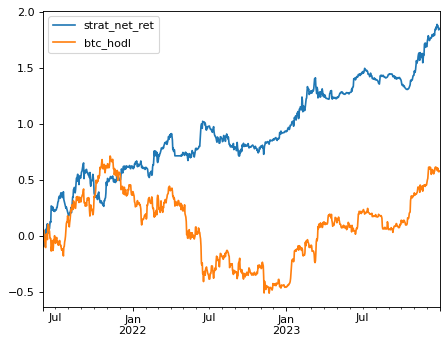

In [24]:
port1, port2 = combined_momentum_strat(px_high_train, px_low_train, px_close_train)

prices = px_close_train
port = eqvol_weights(prices, port1, port2, 60)

ret = prices.ffill().pct_change()

net_ret, gross_ret, turnover = backtest_with_costs(prices[insample_start:], port[insample_start:])

print(f"The average turnover is {turnover.mean()}")
print(f"The holding period is {2/turnover.mean()} days")

return_table = pd.DataFrame({
    'strat_gross_ret': calculate_metrics(gross_ret, True),
    'strat_net_ret': calculate_metrics(net_ret, True),
    'btc_hodl': calculate_metrics(ret['BTCUSDT'].loc[insample_start:]),
})

print(return_table)

overall = pd.DataFrame({
    'strat_net_ret': gross_ret,
    'strat_net_ret': net_ret,
    'btc_hodl': ret['BTCUSDT'].loc[insample_start:]
})

overall.cumsum().plot();

## TEST SET

The average turnover is 0.29117162158378646
The holding period is 6.868801255841094 days
                      strat_gross_ret strat_net_ret     btc_hodl
Cumulative Return             414.79%       261.08%      156.00%
Annualized Return             111.61%        90.36%       68.47%
Annualized Volatility          51.54%        51.62%       49.41%
Sharpe Ratio                 2.165513      1.750453     1.385727
Max Drawdown                  -31.97%       -32.87%      -28.10%
Max Drawdown Duration     113.00 days   113.00 days  237.00 days
Win Rate                       55.96%        53.87%       51.72%
Info Ratio                   2.476881      2.051357          N/A


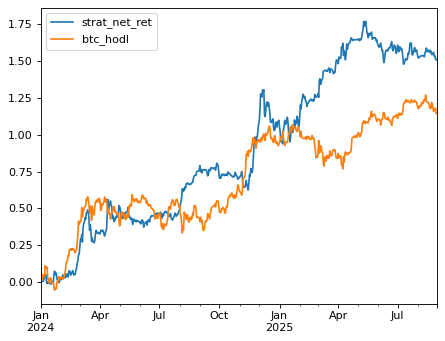

In [25]:
port1, port2 = combined_momentum_strat(px_high, px_low, px_close)

prices = px_close
port = eqvol_weights(prices, port1, port2, 60)

ret = prices.ffill().pct_change()

net_ret, gross_ret, turnover = backtest_with_costs(prices[outsample_start:], port[outsample_start:])

print(f"The average turnover is {turnover.mean()}")
print(f"The holding period is {2/turnover.mean()} days")

return_table = pd.DataFrame({
    'strat_gross_ret': calculate_metrics(gross_ret, True),
    'strat_net_ret': calculate_metrics(net_ret, True),
    'btc_hodl': calculate_metrics(ret['BTCUSDT'].loc[outsample_start:]),
})

print(return_table)

overall = pd.DataFrame({
    'strat_net_ret': gross_ret,
    'strat_net_ret': net_ret,
    'btc_hodl': ret['BTCUSDT'].loc[outsample_start:]
})

overall.cumsum().plot();

In [26]:
overall.cumsum().iloc[-1]

strat_net_ret    1.507622
btc_hodl         1.142456
Name: 2025-08-31 00:00:00, dtype: float64

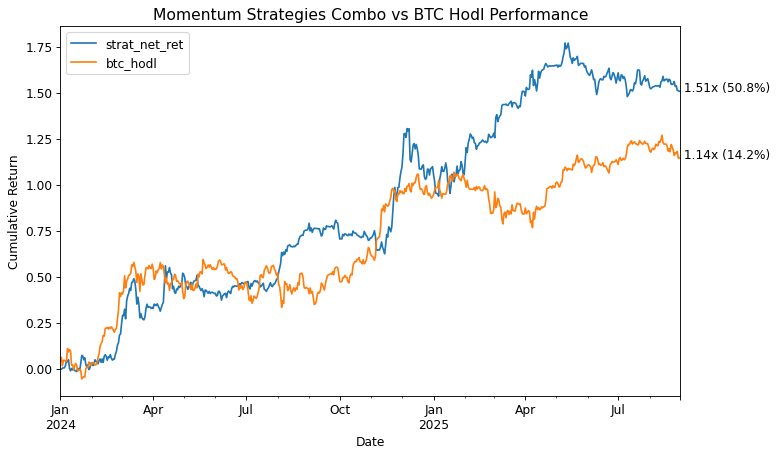

In [27]:
overall = pd.DataFrame({
    'strat_net_ret': net_ret,
    'btc_hodl': ret['BTCUSDT'].loc[outsample_start:]
})

ax = overall.cumsum().plot(title = 'Momentum Strategies Combo vs BTC Hodl Performance',figsize = (10,6));

ax.set_title("Momentum Strategies Combo vs BTC Hodl Performance", fontsize=14)
ax.text(x=overall.cumsum().index[-1], y=overall.cumsum().iloc[-1,0], s=' 1.51x (50.8%)', 
        color="black", fontsize=11)
ax.text(x=overall.cumsum().index[-1], y=overall.cumsum().iloc[-1,1], s=' 1.14x (14.2%)', 
        color="black", fontsize=11)
ax.legend(fontsize=11)
ax.set_xlabel('Date', fontsize=11)     # x-axis label
ax.set_ylabel('Cumulative Return', fontsize=11)
ax.tick_params(axis="x", labelsize=11)
ax.tick_params(axis="y", labelsize=11)

plt.show()

In [28]:
consistency_table = pd.DataFrame({
    'strat_ret_2024': calculate_metrics(net_ret.loc['2024']),
    'strat_ret_2025': calculate_metrics(net_ret.loc['2025']),
})

btc_table = pd.DataFrame({
    'btc_hodl_2024': calculate_metrics(ret['BTCUSDT'].loc['2024']),
    'btc_hodl_2025': calculate_metrics(ret['BTCUSDT'].loc['2025']),
})

print('Strategy Yearly Performance:')
print(consistency_table.to_string(), '\n')

print('----------------------------------------------')
print('BTC Buy and Hold Yearly Performance:')
print(btc_table.to_string())

Strategy Yearly Performance:
                      strat_ret_2024 strat_ret_2025
Cumulative Return            161.57%         38.04%
Annualized Return            109.46%         61.58%
Annualized Volatility         51.76%         51.48%
Sharpe Ratio                 2.11484        1.19627
Max Drawdown                 -26.00%        -26.50%
Max Drawdown Duration    113.00 days    113.00 days
Win Rate                      53.02%         55.14%
Info Ratio                       N/A            N/A 

----------------------------------------------
BTC Buy and Hold Yearly Performance:
                      btc_hodl_2024 btc_hodl_2025
Cumulative Return           121.31%        15.68%
Annualized Return            93.22%        31.20%
Annualized Volatility        53.08%        43.35%
Sharpe Ratio               1.756296      0.719779
Max Drawdown                -26.15%       -28.10%
Max Drawdown Duration   237.00 days   116.00 days
Win Rate                     52.46%        50.62%
Info Ratio       

In [29]:
btc_hodl_ret = ret.loc[outsample_start:]['BTCUSDT']
net_ret.name = 'strat_net_ret'
btc_hodl_ret.name = 'btc_hodl'
df_rets = pd.concat([net_ret, btc_hodl_ret], axis = 1)

strat_net_ret   -0.328658
btc_hodl        -0.280953
dtype: float64


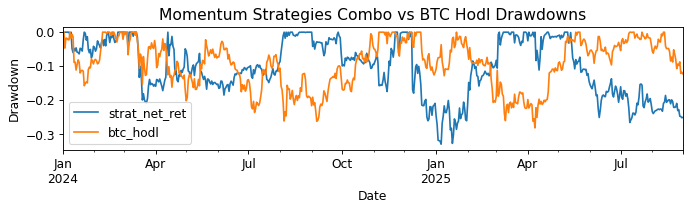

In [30]:
print(drawdown(df_rets).min())
s = drawdown(df_rets)
ax = s.plot( figsize = (10,2), title = "Momentum Strategies Combo vs BTC Hodl Drawdowns", 
            xlabel = "Date", ylabel = "Drawdown");

ax.set_title("Momentum Strategies Combo vs BTC Hodl Drawdowns", fontsize=14)
ax.legend(fontsize=11)
ax.set_xlabel('Date', fontsize=11)     # x-axis label
ax.set_ylabel('Drawdown', fontsize=11)
ax.tick_params(axis="x", labelsize=11)
ax.tick_params(axis="y", labelsize=11)

plt.show()

maximum drawdown -32.8%, the strategy maintained shallower drawdowns and faster recovery throughout the years

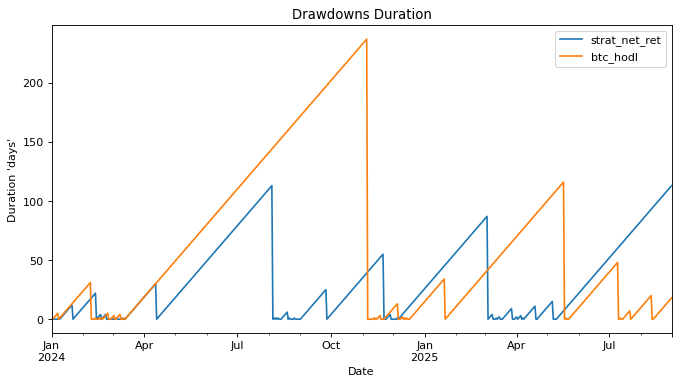

In [31]:
duration(df_rets).plot( figsize = (10,5), title = "Drawdowns Duration", 
                       xlabel = "Date", ylabel = "Duration 'days'");

In [32]:
data = pd.concat([net_ret, btc_hodl_ret], axis=1).dropna()
y = data.iloc[:,0]   # strategy
x = data.iloc[:,1]   # benchmark

#Regression (to get alpha & beta)
X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
alpha_daily, beta = model.params
alpha_ann = alpha_daily * 365  # annualized alpha

# Residual Returns
resid_ret = y - beta * x
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          strat_net_ret   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     22.77
Date:                Tue, 23 Sep 2025   Prob (F-statistic):           2.29e-06
Time:                        10:16:41   Log-Likelihood:                 1346.8
No. Observations:                 609   AIC:                            -2690.
Df Residuals:                     607   BIC:                            -2681.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      2.641      0.0

In [33]:
print("Alpha (annualized):", alpha_ann)
print("Beta:", beta)

Alpha (annualized): 1.0395921250311044
Beta: -0.19863345322680764


- **Alpha (104% annualized)**: The strategy consistently generates excess returns independent of market movements.  
- **Beta (-0.19)**: The negative beta indicates that the strategy tends to move **opposite to the market**, offering a potential hedge and diversification benefit.  

In [34]:
SR = net_ret.mean() / net_ret.std() * np.sqrt(365)
IR = resid_ret.mean() / resid_ret.std() * np.sqrt(365)

print('Strategy Sharpe Ratio is ', SR)
print('Strategy Information Ratio is ', IR)

Strategy Sharpe Ratio is  1.7504530591375833
Strategy Information Ratio is  2.051357140576981


Strategy information ratio is 2.05 which shows consistent and risk efficiency over the benchmark.

At **2.05 IR**, this strategy provides a reliable edge over BTC buy-and-hold

In [35]:
vol = {}
vol['original volatility'] = net_ret.std()*np.sqrt(365)
vol['residual volatility'] = resid_ret.std()*np.sqrt(365)
vol

{'original volatility': 0.516199592170635,
 'residual volatility': 0.5067826096526029}

In [36]:
print('Strategy return correlation with btc hodl return is ', net_ret.corr(btc_hodl_ret))
print('Strategy residual return correlation with btc hodl return is ', resid_ret.corr(btc_hodl_ret))

Strategy return correlation with btc hodl return is  -0.19013946338132182
Strategy residual return correlation with btc hodl return is  -1.2892050651425338e-16
